In [18]:
# importing all the required libraries
import torch
import torch.nn as nn
from torchvision import transforms ,models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision



In [19]:
# some functions which will help us to open image

def get_image(path, img_transform, size = (256,256)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image

# calculation for gram matrix
def get_gram(m):
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t())
    return m

# denormalizing our image to get the actual image
def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


In [20]:
# defining class for extracting the features

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8,15, 22]
        self.vgg = models.vgg16(pretrained=True).features

    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features


In [21]:
# transforming image or normalizing it
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

content_img = get_image('content1.jpg', img_transform)
style_img = get_image('style1.jpg', img_transform)

#starting our generated image with content image with the help of clone method which keeps it in computational graph
generated_img = content_img.clone()    # or nn.Parameter(torch.FloatTensor(content_img.size()))
generated_img.requires_grad = True

# using adam optimizer
optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor()

# freezing the weights in our vgg16 architecture
for p in encoder.parameters():
    p.requires_grad = False



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
content_weight = 1
style_weight = 100

for epoch in range(300):

    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)

    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w)

    loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))


Epoch [0]	Content Loss: 0.0000	Style Loss: 2680.2476
Epoch [20]	Content Loss: 0.9222	Style Loss: 1951.8840
Epoch [40]	Content Loss: 1.4415	Style Loss: 1345.3977
Epoch [60]	Content Loss: 1.6291	Style Loss: 973.9960
Epoch [80]	Content Loss: 1.7247	Style Loss: 761.5193
Epoch [100]	Content Loss: 1.7937	Style Loss: 632.1182
Epoch [120]	Content Loss: 1.8600	Style Loss: 544.3719
Epoch [140]	Content Loss: 1.9201	Style Loss: 479.8218
Epoch [160]	Content Loss: 1.9749	Style Loss: 429.7555
Epoch [180]	Content Loss: 2.0281	Style Loss: 389.6947
Epoch [200]	Content Loss: 2.0768	Style Loss: 356.8361
Epoch [220]	Content Loss: 2.1208	Style Loss: 329.3385
Epoch [240]	Content Loss: 2.1613	Style Loss: 305.8402
Epoch [260]	Content Loss: 2.1952	Style Loss: 285.5230
Epoch [280]	Content Loss: 2.2232	Style Loss: 267.6483


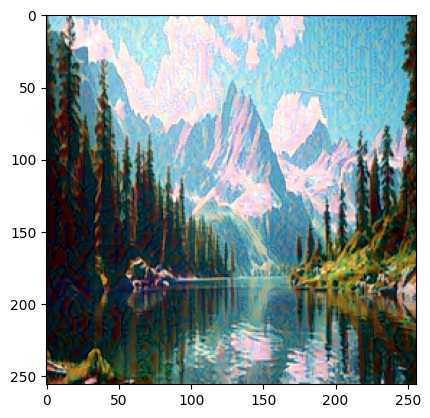

In [23]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)


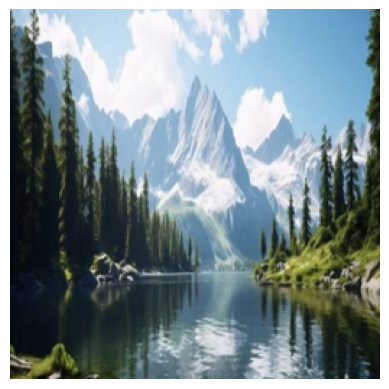

In [28]:
img = Image.open('content1.jpg')

# Step 2: Resize the image
img = img.resize((256, 256))

# Step 3: Convert the image to a format suitable for matplotlib
# (PIL images are already in the format (height, width, channels))
img_array = np.array(img)

# Step 4: Display the image using matplotlib
plt.imshow(img_array)
plt.axis('off')  # Turn off the axis
plt.show()



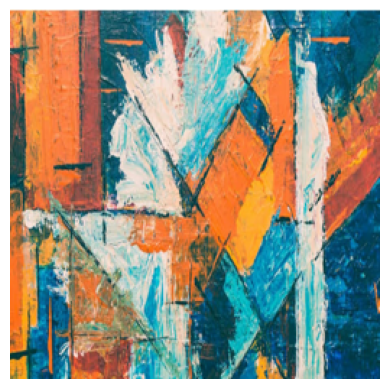

In [30]:
img = Image.open('style1.jpg')

# Step 2: Resize the image
img = img.resize((256, 256))

# Step 3: Convert the image to a format suitable for matplotlib
# (PIL images are already in the format (height, width, channels))
img_array = np.array(img)

# Step 4: Display the image using matplotlib
plt.imshow(img_array)
plt.axis('off')  # Turn off the axis
plt.show()

